In [3]:
! pip install opencv-python

In [4]:
from __future__ import print_function
#tensorflow
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
#import tarfile
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import random
path= './model/'

In [5]:
img_class = 1 #fish
demo_target = 422 # "barbell"

(299, 299, 3)


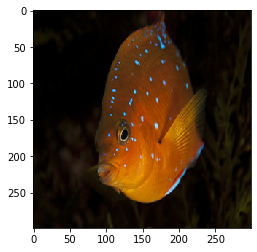

In [6]:
img=cv2.imread(path+'fish.jpg')
new_w = 299 
new_h = 299 
img = cv2.resize(img,(new_h, new_w), interpolation = cv2.INTER_CUBIC)
img=img[0:299,0:299]
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = (np.asarray(img) / 255.0).astype(np.float32)
plt.imshow(img)
print(img.shape)

In [7]:
#interactive sesion
tf.logging.set_verbosity(tf.logging.ERROR)
sess=tf.InteractiveSession()

image=tf.Variable(tf.zeros((299,299,3)))
imagelist = tf.placeholder(tf.float32, shape=[None, 299, 299, 3])

In [8]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False)

In [10]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess,'./model/inception_v3.ckpt')
with open('./model/imagenet.json') as f:
    imagenet_labels = json.load(f)

In [11]:
def shear_transform(img,shear_range):
    rows,cols,ch = img.shape
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img,shear_M,(cols,rows))


def translation_transform(img,trans_range):
    rows,cols,ch = img.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    return cv2.warpAffine(img,Trans_M,(cols,rows))

def gamma_transform(img):
    gamma = random.uniform(1, 3)
    img = (img)**(1/gamma)
    return (img)

def rotate_transform(img, angle):
    rows,cols,ch=img.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(img, rotation_matrix, (cols, rows))

def blur_transform(img):
    k = random.randrange(3,8,2)
    return cv2.GaussianBlur(img,(k,k),0)

def augmentation(img):
    r = np.random.randint(4, size=1)
    #print(r)
    if(r==0):
        img = blur_transform(img)
    if(r==1):
        img = gamma_transform(img)
    #if(r[1]==1):
    #    img = shear_transform(img,5)
    if(r==2):
        img = rotate_transform(img,random.randint(-60,60))
    if(r==3):
        img = translation_transform(img,10)
    return img

In [12]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Start with normal example, not transformation

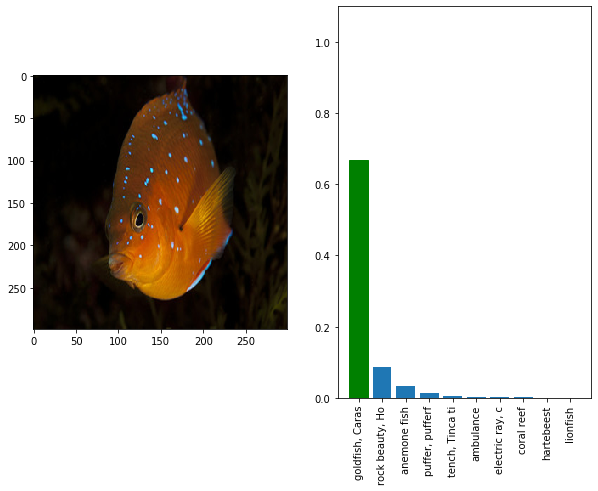

In [13]:
## Before image
classify(img,correct_class=img_class)

In [14]:
x = tf.placeholder(tf.float32,(299,299,3))
x_hat = image #trainable variable that we created
assign_op = tf.assign(x_hat,x)

learning_rate = tf.placeholder(tf.float32,())
y_hat = tf.placeholder(tf.int32,())

labels = tf.one_hot(y_hat,1000)

In [18]:
epsilon = tf.placeholder(tf.float32,())

below = x-epsilon
above = x+epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat,below,above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat,projected)

## minimize the cross entropy with selected target class

In [19]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
      learning_rate).minimize(loss,var_list=[x_hat])

demo_epsilon=2.0/255.0 #small disturbance
demo_lr=1e-1
demo_steps=100

#initializtion
sess.run(assign_op,feed_dict={x:img})

# project gradient descent
for i in range(demo_steps):
    _,loss_value=sess.run([optim_step,loss],feed_dict={learning_rate:demo_lr,y_hat:demo_target})
    
    #project step - cliping the image in case her bounderies are x<0 or x>1
    sess.run(project_step,feed_dict={x:img,epsilon:demo_epsilon})
    if(i+1)%10==0:
        print('Steps: %d, Loss: %g' % (i+1,loss_value))
        
adv=x_hat.eval()

Steps: 10, Loss: 2.41531
Steps: 20, Loss: 0.000333969
Steps: 30, Loss: 0.000221943
Steps: 40, Loss: 0.000171647
Steps: 50, Loss: 0.000143041
Steps: 60, Loss: 0.000123016
Steps: 70, Loss: 0.000108355
Steps: 80, Loss: 9.73892e-05
Steps: 90, Loss: 8.86878e-05
Steps: 100, Loss: 8.15358e-05


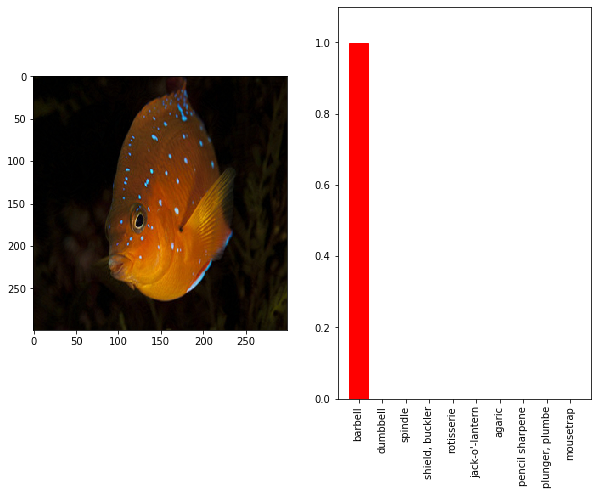

In [20]:
classify(adv,correct_class=img_class,target_class=demo_target)

## looking at the noise

True

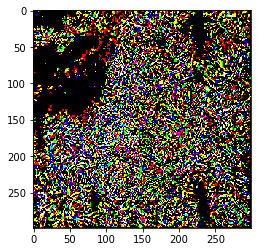

In [14]:
plt.imshow(adv-img)
cv2.imwrite('advnoise.png',(adv-img)*255)

## now for a simple example of EOT with rotation

### First, rotate at some angle and try to classify

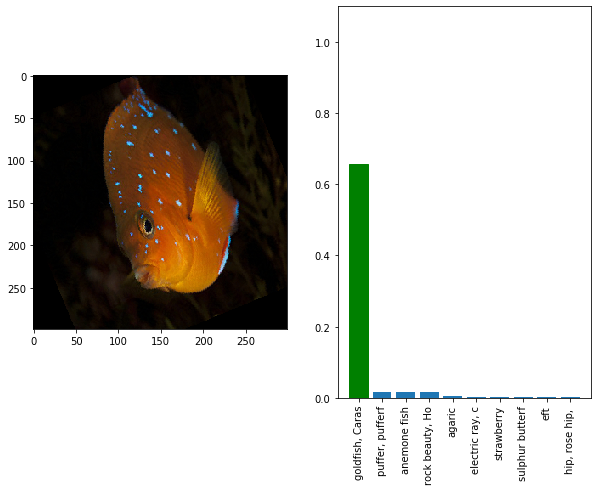

In [21]:
ex_angle=np.pi/8
angle=tf.placeholder(tf.float32,())
rotated_image=tf.contrib.image.rotate(image,angle)
rotated_example=rotated_image.eval(feed_dict={image:adv,angle: ex_angle})
classify(rotated_example,correct_class=img_class,target_class=demo_target)

In [22]:
num_samples=10
average_loss=0
for i in range(num_samples):
    # sample a rotation
    rotated=tf.contrib.image.rotate(image,tf.random_uniform((),minval = -np.pi/4,maxval = np.pi/4))
    # calulate logits
    rotated_logits,_ = inception(rotated,reuse=True)
    # instead of older loss - we now take the avg over all transformations(rotations)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(logits=rotated_logits,labels=labels)/num_samples


## Old! optimization
optim_step = tf.train.GradientDescentOptimizer(
      learning_rate).minimize(loss,var_list=[x_hat])

## New! optimization - difference is the average_loss
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss,var_list=[x_hat])

In [ ]:
demo_epsilon = 10.0/255.0 # a bigger radius of change
demo_lr = 3e-1
demo_steps = 500

sess.run(assign_op,feed_dict={x:img})
    
for i in range(demo_steps):
    _,loss_value=sess.run([optim_step,average_loss],
             feed_dict={learning_rate:demo_lr,y_hat:demo_target})
    
    sess.run(project_step, feed_dict={x:img,epsilon:demo_epsilon})
    if(i+1)%50==0:
        print('Step: %d, Loss: %g' % (i+1,loss_value))


adv_rotated=x_hat.eval()

Step: 50, Loss: 0.00134426


In [ ]:
plt.imshow(adv_rotated-img)

In [ ]:
checked_angles = [np.pi/8, 0, -np.pi/6]
for angle in checked_angles:
    print(angle)
    rotated_example=rotated_image.eval(feed_dict={image: adv_rotated, angle:angle})
    classify(rotated_example,correct_class=img_class,target_class=demo_target)

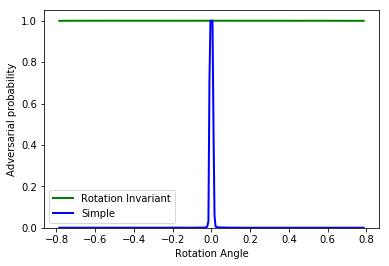

In [20]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_rotated, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='g', linewidth=2, label='Rotation Invariant')
naive_line, = plt.plot(thetas, p_naive, color='b', linewidth=2, label='Simple')
plt.ylim([0, 1.05])
plt.xlabel('Rotation Angle')
plt.ylabel('Adversarial probability')
plt.legend(handles=[robust_line, naive_line], loc='lower left')
plt.show()